In [4]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

In [5]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_OPENED = -1
USER_IGNORED = 0

In [6]:
users = ['Male', 'Female']
times_of_day = ['morning', 'afternoon']
actions = ["title_1", "title_2", "title_3", "title_4"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [7]:
def reward_func(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_3':
            return USER_OPENED
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_1':
            return USER_OPENED
        else:
            return USER_IGNORED
get_preference_matrix(reward_func)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon          -1        0        0        0
       morning             0       -1        0        0
Male   afternoon           0        0       -1        0
       morning            -1        0        0        0

### 2nd One

In [8]:
def reward_func_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_3':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new1)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0       -1        0        0
       morning             0        0       -1        0
Male   afternoon           0       -1        0        0
       morning            -1        0        0        0

### 3rd One

In [9]:
def reward_func_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'title_4':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new2)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0        0        0       -1
       morning             0        0        0       -1
Male   afternoon           0        0        0       -1
       morning            -1        0        0        0

In [10]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [11]:
context = {"user":"Male","time_of_day":"morning"}
# actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]
actions = ["title_1", "title_2", "title_3", "title_4"]

print(to_vw_example_format(context,actions))

shared |User user=Male time_of_day=morning
|Action article=title_1 
|Action article=title_2 
|Action article=title_3 
|Action article=title_4 


In [12]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [13]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [14]:
def plot_ctr(num_iterations, ctr,label):
    plt.plot(range(1,num_iterations+1), ctr,label=label)
    plt.xlabel('num_emails = totall num / 3', fontsize=14)
    plt.ylabel('Rewared', fontsize=14)
    plt.ylim([0,1])
    plt.legend(loc='lower right',fancybox=True, shadow=True, ncol=2)

In [15]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter , end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
#             print("cost",cost)
            cost_sum += cost
#             print("sum",cost_sum)
            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)
                # 7. Let VW know you're done with these objects
                vw.finish_example(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
        
    return ctr

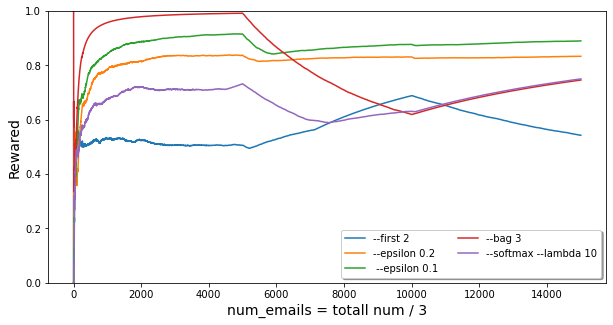

In [16]:
ctr = []
plt.figure(figsize=(10,5))
model = pyvw.vw(quiet=True)
# Instantiate learner in VW
# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]

# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]


# exploration_algo = ["--first 2", "--first 4","--first 6"]
# exploration_algo = ["--epsilon 0.05","--epsilon 0.1","--epsilon 0.15","--epsilon 0.2"]
# exploration_algo = ["--bag 1","--bag 3","--bag 5","--bag 7"]
# exploration_algo = ["--softmax --lambda 6","--softmax --lambda 8","--softmax --lambda 10","--softmax --lambda 12"]
# exploration_algo = ["--rnd 3 --epsilon 0.025","--rnd 3 --epsilon 0.025","--rnd 1 --epsilon 0.025" ]


exploration_algo = ["--first 2","--epsilon 0.2"," --epsilon 0.1" , "--bag 3","--softmax --lambda 10"]

# exploration_algo = ["--epsilon 0.1" ," --epsilon 0.2" , "--softmax --lambda 10", "--bag 5"]
for algo in exploration_algo:
    model = pyvw.vw("--cb_explore_adf -q UA --quiet " + algo)
    # vw = pyvw.vw("--cb_explore_adf -q UA --quiet")  cubic UAK 

    num_iterations = 5000
    

    
# **********************************************************
#     USER_OPENED or USER_IGNORED
    cost_functions = [reward_func, reward_func_new1, reward_func_new2]

    
# **********************************************************
# np.random.choice([0,-1],p=[0.3,0.7])
#     cost_functions = [reward_func_choice, reward_func_choice_new1 ,reward_func_choice_new2]
    
# **********************************************************
# np.random.normal(-1,0.075)   
#     cost_functions = [reward_func_normaldist, reward_func_normaldist_new1, reward_func_normaldist_new2]

    total_iterations = num_iterations * len(cost_functions)
#     print(total_iterations)
    ctr.append(run_simulation_multiple_cost_functions(model, num_iterations, users, times_of_day, actions, cost_functions))
               
    plot_ctr(total_iterations, ctr[-1],algo)
    

In [17]:
b = {
    '1': "Male",
    '2': "Female",
    }
v= {
    '1': "morning",
    '2': "afternoon",
    }
# print("User:" , b , " Time of the day :" , v)

In [23]:
def guess_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    print(actions)
    print(pmf)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob


print("Please choose the user's Gender:  1 for Male  OR  2  for Female ")
usr = input()
print()
print("Please choose  Time of the day:  1 for Morning  OR  2  for Afternoon ")
tof = input()
print()
print("The user is --",b.get(usr), "-- And Time of the day is --",v.get(tof),"--")
print()

    
# context = {"user":"Fale","time_of_day":"morning","Media_type":"photo" }
context = {"user":b.get(usr),"time_of_day":v.get(tof)}
# context = {"user":"Male","time_of_day":"afternoon"}
action, prob = guess_action(model, context, actions)
print("Send: ",action)


# print("Send: ",action,prob)

Please choose the user's Gender:  1 for Male  OR  2  for Female 
1

Please choose  Time of the day:  1 for Morning  OR  2  for Afternoon 
1

The user is -- Male -- And Time of the day is -- morning --

['title_1', 'title_2', 'title_3', 'title_4']
[0.999884843826294, 1.1534994293072032e-08, 2.3953739969329035e-07, 0.00011489893950056285]
Send:  title_1


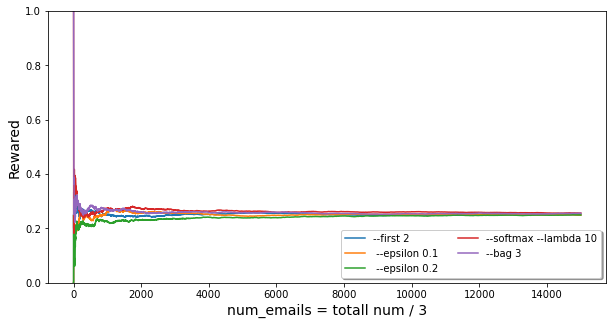

In [34]:
ctr = []
plt.figure(figsize=(10,5))
model = pyvw.vw(quiet=True)
# Instantiate learner in VW
# exploration_algo = ["--first 2", "--epsilon 0.1", "--bag 3", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]
exploration_algo = ["--first 2"," --epsilon 0.1" ," --epsilon 0.2" , "--softmax --lambda 10", "--bag 3"]
for algo in exploration_algo:
    model = pyvw.vw("--cb_explore_adf cubic UAK --quiet " + algo)
    # vw = pyvw.vw("--cb_explore_adf -q UA --quiet") cubic UAK 

    num_iterations = 5000
    
# **********************************************************
#     USER_OPENED or USER_IGNORED
    cost_functions = [reward_func, reward_func_new1, reward_func_new2]
    
# **********************************************************


# np.random.choice([0,-1],p=[0.3,0.7])
#     cost_functions = [reward_func_choice, reward_func_choice_new1 ,reward_func_choice_new2]
    
# **********************************************************
# np.random.normal(-1,0.075)   
#     cost_functions = [reward_func_normaldist, reward_func_normaldist_new1, reward_func_normaldist_new2]

    total_iterations = num_iterations * len(cost_functions)
#     print(total_iterations)
    ctr.append(run_simulation_multiple_cost_functions(model, num_iterations, users, times_of_day, actions, cost_functions,do_learn=False))
               
    plot_ctr(total_iterations, ctr[-1],algo)

In [35]:
def guess_action(vw, context, actions):
    
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    print(actions,pmf)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

context = {"user":"Female","time_of_day":"morning" }
action, prob = guess_action(model, context, actions)
print("Send: ",action)
# print(action,prob)

['title_1', 'title_2', 'title_3', 'title_4'] [0.25, 0.25, 0.25, 0.25]
Send:  title_4


# <span style="color:red"> **Distributions** </span>

### 1st One
np.random.choice([0,-1],p=[0.3,0.7])

In [23]:
def reward_func_choice(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'title_3':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return np.random.choice([0,-1],p=[0.3,0.7])  
        elif context['time_of_day'] == "afternoon" and action == 'title_1':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0        0        0        0
       morning             0        0        0        0
Male   afternoon           0        0        0        0
       morning            -1        0        0        0

In [24]:
def reward_func_choice_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return np.random.choice([0,-1],p=[0.3,0.7])
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return np.random.choice([0,-1],p=[0.4,0.6])
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return np.random.choice([0,-1],p=[0.4,0.6])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice_new1)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0        0        0        0
       morning             0       -1        0        0
Male   afternoon           0       -1        0        0
       morning            -1        0        0        0

In [25]:
def reward_func_choice_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.choice([0,-1],p=[0.3,0.7])
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.choice([0,-1],p=[0.1,0.9])
        else:
            return USER_IGNORED
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'title_4':
            return np.random.choice([0,-1],p=[0.1,0.9])
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.choice([0,-1],p=[0.1,0.9])
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_choice_new2)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0        0        0       -1
       morning             0        0        0        0
Male   afternoon           0        0        0       -1
       morning            -1        0        0        0

## 2nd One

USER_OPENED or USER_IGNORED

In [385]:
def reward_func(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_3':
            return USER_OPENED
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_1':
            return USER_OPENED
        else:
            return USER_IGNORED
get_preference_matrix(reward_func)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon          -1        0        0        0
       morning             0       -1        0        0
Male   afternoon           0        0       -1        0
       morning            -1        0        0        0

In [390]:
def reward_func_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new1)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0       -1        0        0
       morning             0       -1        0        0
Male   afternoon           0       -1        0        0
       morning            -1        0        0        0

In [391]:
def reward_func_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'title_4':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return USER_OPENED
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_new2)

actions              title_1  title_2  title_3  title_4
users  times_of_day                                    
Female afternoon           0        0        0       -1
       morning             0        0        0       -1
Male   afternoon           0        0        0       -1
       morning            -1        0        0        0

## 3rd One

np.random.normal(-1,0.075) 

In [392]:
def reward_func_normaldist(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_3':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
        
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_1':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
get_preference_matrix(reward_func_normaldist)

actions               title_1   title_2   title_3  title_4
users  times_of_day                                       
Female afternoon    -0.948903  0.000000  0.000000      0.0
       morning       0.000000 -1.020054  0.000000      0.0
Male   afternoon     0.000000  0.000000 -0.959202      0.0
       morning      -0.887162  0.000000  0.000000      0.0

In [30]:
def reward_func_normaldist_new1(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_normaldist_new1)

actions               title_1   title_2  title_3  title_4
users  times_of_day                                      
Female afternoon     0.000000 -0.945148      0.0      0.0
       morning       0.000000 -0.956170      0.0      0.0
Male   afternoon     0.000000 -1.030592      0.0      0.0
       morning      -0.960941  0.000000      0.0      0.0

In [31]:
def reward_func_normaldist_new2(context,action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
    elif context['user'] == "Female": 
        if context['time_of_day'] == "morning" and action == 'title_4':
            return np.random.normal(-1,0.075) 
        elif context['time_of_day'] == "afternoon" and action == 'title_4':
            return np.random.normal(-1,0.075) 
        else:
            return USER_IGNORED
        
get_preference_matrix(reward_func_normaldist_new2)

actions               title_1  title_2  title_3   title_4
users  times_of_day                                      
Female afternoon     0.000000      0.0      0.0 -1.110474
       morning       0.000000      0.0      0.0 -1.104825
Male   afternoon     0.000000      0.0      0.0 -1.019714
       morning      -1.002523      0.0      0.0  0.000000